In [2]:
import pandas as pd
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import json
from IPython.display import display, Markdown
from scipy.stats import pearsonr, spearmanr, ks_2samp, mannwhitneyu, ttest_ind

import sys
sys.path.append('../')

import utils
from evalutils.roc import get_bootstrapped_roc_ci_curves
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

## directory where results are
EXPERIMENT_DIR = f"/data/bodyct/experiments/lung-malignancy-fairness-shaurya"
dlcst_preds = f"{EXPERIMENT_DIR}/nlst"

TEAMS_DIR = "C:/Users/shaur/OneDrive - Radboudumc/Documents - Master - Shaurya Gaur/General/Malignancy-Estimation Results"
DLCST_PREDS = f"{TEAMS_DIR}/dlcst" ## Comment out if not using Teams backup (aka Chansey is up :)

In [3]:
dlcst_preds = pd.read_csv(f"{DLCST_PREDS}/dlcst_thijmen_kiran_sybil_malignancy_estimation_results.csv", header=0)
dlcst_preds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 599 entries, 0 to 598
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   PatientID            599 non-null    int64  
 1   StudyDate            599 non-null    int64  
 2   SeriesInstanceUID    599 non-null    object 
 3   Age                  599 non-null    int64  
 4   Sex                  599 non-null    int64  
 5   FamilyHistoryLungCa  599 non-null    int64  
 6   Emphysema            599 non-null    int64  
 7   NoduleCountPerScan   599 non-null    int64  
 8   sybil_year1          599 non-null    float64
 9   sybil_year2          599 non-null    float64
 10  sybil_year3          599 non-null    float64
 11  sybil_year4          599 non-null    float64
 12  sybil_year5          599 non-null    float64
 13  sybil_year6          599 non-null    float64
 14  PanCan2b             599 non-null    float64
 15  Ensemble_Kiran       599 non-null    flo

In [29]:
dlcst_democols = {'cat': {'all': ['Sex', 'FamilyHistoryLungCa', 'Emphysema']}, 'num': {'all': ['Age', 'NoduleCountPerScan']}}

In [13]:
dlcst_policy_thresholds = pd.read_csv(f"{DLCST_PREDS}/policy-thresholds-{len(dlcst_preds)}.csv", index_col=0)
dlcst_policy_thresholds

,Sensitivity=0.9,Specificity=0.9,Youden J=1.0,Brock
Venkadesh,0.128,0.323,0.105,0.06
de Haas,0.195,0.360,0.213,0.06
Sybil,0.002,0.013,0.005,0.06
PanCan2b,0.029,0.093,0.029,0.06


In [5]:
THRESHOLD = 'Brock'

Sybil's worse columns are from our [scan level AUC results](./plot_nlst_scanlevel.ipynb).

PanCan columns from [Radiopaedia](https://radiopaedia.org/articles/brock-model-for-pulmonary-nodules).

The gender differential columns are from the "What about men vs women?" section of the [training info demographic splits notebook](./nlst/nlst_traininfo.ipynb).

In [7]:
dlcst_preds[['sybil_year1']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 599 entries, 0 to 598
Data columns (total 1 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   sybil_year1  599 non-null    float64
dtypes: float64(1)
memory usage: 4.8 KB


In [8]:
MODEL_TO_COL = {
    "Venkadesh": "Ensemble_Kiran",
    "de Haas": "thijmen_mean",
    "Sybil": "sybil_year1",
    "PanCan2b": "PanCan2b",
}

In [14]:
dlcst_preds['Sybil_pred_label'] = (dlcst_preds[MODEL_TO_COL['Sybil']] > dlcst_policy_thresholds.loc['Sybil', THRESHOLD]).astype(int).to_numpy()
dlcst_preds['Sybil_PanCan_diff'] = dlcst_preds[MODEL_TO_COL['Sybil']] - dlcst_preds['PanCan2b']

In [15]:
false_positives = dlcst_preds.query("label == 0 and Sybil_pred_label == 1")
false_negatives = dlcst_preds.query("label == 1 and Sybil_pred_label == 0")

true_positives = dlcst_preds.query("label == 1 and Sybil_pred_label == 1")
true_negatives = dlcst_preds.query("label == 0 and Sybil_pred_label == 0")

## Difference between Training Info Splits

In [16]:
result_sets = {
    "FP": false_positives,
    "FN": false_negatives,
    "TP": true_positives,
    "TN": true_negatives, 
}

### utility code

In [18]:
def combine_col_dfs(cols=dlcst_democols, df_func=pd.DataFrame, dfsets=result_sets, dispdf=False):
    splitdfs = []
    for cat in cols:
        if dispdf: display(Markdown(f"### {cat}"))
        
        for c in cols[cat]:
            df = df_func(c, dfsets)
            if dispdf: display(df)

            df['category'] = [cat] * len(df)
            df['attribute'] = [c] * len(df)
            df['value'] = df.index.values
            
            dfcols = df.columns.tolist()
            dfcols = dfcols[-3:] + dfcols[:-3]
            df = df[dfcols]
            df.reset_index(inplace=True, drop=True)
            df.sort_values(by='value', ascending=True, inplace=True)

            splitdfs.append(df)

    return pd.concat(splitdfs, axis=0, ignore_index=True)

In [19]:
def cat_dist_df(c='Sex', dfsets=result_sets):
    dfdict = {}
    for m in dfsets:
        dfdict[f"{m}_freq"] = dfsets[m][c].value_counts(normalize=False, dropna=False).astype(int)
        dfdict[f"{m}_norm"] = 100 * dfsets[m][c].value_counts(normalize=True, dropna=False).round(6)
        dfdict[f"{m}_freq"].fillna(0, inplace=True)
        dfdict[f"{m}_norm"].fillna(0, inplace=True)
    
    for i, m1 in enumerate(dfsets):
        for j, m2 in enumerate(dfsets):
            if j > i:
                # dfdict[f"diff_freq_{m1}_{m2}"] = (dfdict[f"{m1}_freq"] - dfdict[f"{m2}_freq"]).round(4)
                dfdict[f"diff_norm_{m1}_{m2}"] = (dfdict[f"{m1}_norm"] - dfdict[f"{m2}_norm"]).round(4)
    
    df = pd.DataFrame(dfdict).drop_duplicates()

    for m in dfsets:
        df[f"{m}_freq"] = df[f"{m}_freq"].fillna(0.0)
        df[f"{m}_norm"] = df[f"{m}_norm"].fillna(0.0)

    for i, m1 in enumerate(dfsets):
        for j, m2 in enumerate(dfsets):
            if j > i:
                # dfdict[f"diff_freq_{m1}_{m2}"] = (dfdict[f"{m1}_freq"] - dfdict[f"{m2}_freq"]).round(4)
                df[f"diff_norm_{m1}_{m2}"] = (df[f"{m1}_norm"] - df[f"{m2}_norm"]).round(4)    

    # df = pd.DataFrame(dfdict).drop_duplicates()
    return df

In [20]:
def num_dist_df(c='Sex', dfsets=result_sets):
    dfdict = {}
    for m in dfsets:
        dfdict[f"{m}"] = dfsets[m][c].describe(percentiles=[0.5]).round(4)
    
    for i, m1 in enumerate(dfsets):
        for j, m2 in enumerate(dfsets):
            if j > i:
                dfdict[f"diff_{m1}_{m2}"] = dfdict[f"{m1}"] - dfdict[f"{m2}"]
    
    df = pd.DataFrame(dfdict).drop_duplicates()
    df.drop(index=['count', 'max', 'min', 'std'], inplace=True)
    return df

### differences

In [31]:
cat_demo_splits = combine_col_dfs(dlcst_democols['cat'], cat_dist_df, result_sets)
display(cat_demo_splits.sort_values(by='diff_norm_FP_FN', ascending=False))
cat_demo_splits.sort_values(by='diff_norm_FP_FN', ascending=True)

,category,attribute,value,FP_freq,FP_norm,FN_freq,FN_norm,TP_freq,TP_norm,TN_freq,TN_norm,diff_norm_FP_FN,diff_norm_FP_TP,diff_norm_FP_TN,diff_norm_FN_TP,diff_norm_FN_TN,diff_norm_TP_TN
5,all,Emphysema,1,21,80.7692,20,71.4286,24,77.4194,340,66.1479,9.3406,3.3498,14.6213,-5.9908,5.2807,11.2715
2,all,FamilyHistoryLungCa,0,21,80.7692,20,71.4286,23,74.1935,433,84.2412,9.3406,6.5757,-3.4720,-2.7649,-12.8126,-10.0477
0,all,Sex,1,15,57.6923,14,50.0000,18,58.0645,276,53.6965,7.6923,-0.3722,3.9958,-8.0645,-3.6965,4.3680
1,all,Sex,2,11,42.3077,14,50.0000,13,41.9355,238,46.3035,-7.6923,0.3722,-3.9958,8.0645,3.6965,-4.3680
3,all,FamilyHistoryLungCa,1,5,19.2308,8,28.5714,8,25.8065,81,15.7588,-9.3406,-6.5757,3.4720,2.7649,12.8126,10.0477
4,all,Emphysema,0,5,19.2308,8,28.5714,7,22.5806,174,33.8521,-9.3406,-3.3498,-14.6213,5.9908,-5.2807,-11.2715


,category,attribute,value,FP_freq,FP_norm,FN_freq,FN_norm,TP_freq,TP_norm,TN_freq,TN_norm,diff_norm_FP_FN,diff_norm_FP_TP,diff_norm_FP_TN,diff_norm_FN_TP,diff_norm_FN_TN,diff_norm_TP_TN
3,all,FamilyHistoryLungCa,1,5,19.2308,8,28.5714,8,25.8065,81,15.7588,-9.3406,-6.5757,3.4720,2.7649,12.8126,10.0477
4,all,Emphysema,0,5,19.2308,8,28.5714,7,22.5806,174,33.8521,-9.3406,-3.3498,-14.6213,5.9908,-5.2807,-11.2715
1,all,Sex,2,11,42.3077,14,50.0000,13,41.9355,238,46.3035,-7.6923,0.3722,-3.9958,8.0645,3.6965,-4.3680
0,all,Sex,1,15,57.6923,14,50.0000,18,58.0645,276,53.6965,7.6923,-0.3722,3.9958,-8.0645,-3.6965,4.3680
2,all,FamilyHistoryLungCa,0,21,80.7692,20,71.4286,23,74.1935,433,84.2412,9.3406,6.5757,-3.4720,-2.7649,-12.8126,-10.0477
5,all,Emphysema,1,21,80.7692,20,71.4286,24,77.4194,340,66.1479,9.3406,3.3498,14.6213,-5.9908,5.2807,11.2715


In [33]:
num_demo_splits = combine_col_dfs(dlcst_democols['num'], num_dist_df, result_sets)
display(num_demo_splits.sort_values(by='diff_FP_FN', ascending=False))
num_demo_splits.sort_values(by='diff_FP_FN', ascending=True)

,category,attribute,value,FP,FN,TP,TN,diff_FP_FN,diff_FP_TP,diff_FP_TN,diff_FN_TP,diff_FN_TN,diff_TP_TN
2,all,NoduleCountPerScan,50%,2.0000,2.0000,1.0000,1.0000,0.0000,1.0000,1.0000,1.0000,1.0000,0.0000
3,all,NoduleCountPerScan,mean,1.8462,2.0714,1.3871,1.7724,-0.2252,0.4591,0.0738,0.6843,0.2990,-0.3853
1,all,Age,mean,60.1154,60.5000,63.3548,57.8969,-0.3846,-3.2394,2.2185,-2.8548,2.6031,5.4579
0,all,Age,50%,59.5000,60.5000,64.0000,58.0000,-1.0000,-4.5000,1.5000,-3.5000,2.5000,6.0000


,category,attribute,value,FP,FN,TP,TN,diff_FP_FN,diff_FP_TP,diff_FP_TN,diff_FN_TP,diff_FN_TN,diff_TP_TN
0,all,Age,50%,59.5000,60.5000,64.0000,58.0000,-1.0000,-4.5000,1.5000,-3.5000,2.5000,6.0000
1,all,Age,mean,60.1154,60.5000,63.3548,57.8969,-0.3846,-3.2394,2.2185,-2.8548,2.6031,5.4579
3,all,NoduleCountPerScan,mean,1.8462,2.0714,1.3871,1.7724,-0.2252,0.4591,0.0738,0.6843,0.2990,-0.3853
2,all,NoduleCountPerScan,50%,2.0000,2.0000,1.0000,1.0000,0.0000,1.0000,1.0000,1.0000,1.0000,0.0000


### Now with the top 100 scores that were different from PanCan

In [50]:
result_top_100_diff = {
    "FP": false_positives.sort_values(by=['Sybil_PanCan_diff'], ascending=False)[0:100],
    "FN": false_negatives.sort_values(by=['Sybil_PanCan_diff'], ascending=False)[0:100],
}

In [51]:
cat_demo_splits = combine_col_dfs(dlcst_democols['cat'], cat_dist_df, result_top_100_diff)
display(cat_demo_splits.sort_values(by='diff_norm_FP_FN', ascending=False))
cat_demo_splits.sort_values(by='diff_norm_FP_FN', ascending=True)

,category,attribute,value,FP_freq,FP_norm,FN_freq,FN_norm,diff_norm_FP_FN
5,all,Emphysema,1,21,80.7692,20,71.4286,9.3406
2,all,FamilyHistoryLungCa,0,21,80.7692,20,71.4286,9.3406
0,all,Sex,1,15,57.6923,14,50.0000,7.6923
1,all,Sex,2,11,42.3077,14,50.0000,-7.6923
3,all,FamilyHistoryLungCa,1,5,19.2308,8,28.5714,-9.3406
4,all,Emphysema,0,5,19.2308,8,28.5714,-9.3406


,category,attribute,value,FP_freq,FP_norm,FN_freq,FN_norm,diff_norm_FP_FN
3,all,FamilyHistoryLungCa,1,5,19.2308,8,28.5714,-9.3406
4,all,Emphysema,0,5,19.2308,8,28.5714,-9.3406
1,all,Sex,2,11,42.3077,14,50.0000,-7.6923
0,all,Sex,1,15,57.6923,14,50.0000,7.6923
2,all,FamilyHistoryLungCa,0,21,80.7692,20,71.4286,9.3406
5,all,Emphysema,1,21,80.7692,20,71.4286,9.3406


In [52]:
num_demo_splits = combine_col_dfs(dlcst_democols['num'], num_dist_df, result_top_100_diff)
display(num_demo_splits.sort_values(by='diff_FP_FN', ascending=False))
num_demo_splits.sort_values(by='diff_FP_FN', ascending=True)

,category,attribute,value,FP,FN,diff_FP_FN
2,all,NoduleCountPerScan,50%,2.0000,2.0000,0.0000
3,all,NoduleCountPerScan,mean,1.8462,2.0714,-0.2252
1,all,Age,mean,60.1154,60.5000,-0.3846
0,all,Age,50%,59.5000,60.5000,-1.0000


,category,attribute,value,FP,FN,diff_FP_FN
0,all,Age,50%,59.5000,60.5000,-1.0000
1,all,Age,mean,60.1154,60.5000,-0.3846
3,all,NoduleCountPerScan,mean,1.8462,2.0714,-0.2252
2,all,NoduleCountPerScan,50%,2.0000,2.0000,0.0000


## False Positives

In [63]:
false_positives = dlcst_preds.query("label == 0 and Sybil_pred_label == 1")
false_positives.sort_values(by=['Sybil_PanCan_diff'], ascending=False)[['SeriesInstanceUID', 'label', 'Sybil_pred_label', 'PanCan2b', 'sybil_year1', 'Sybil_PanCan_diff']]
len(false_positives)

26

<Axes: xlabel='Sybil_PanCan_diff', ylabel='Count'>

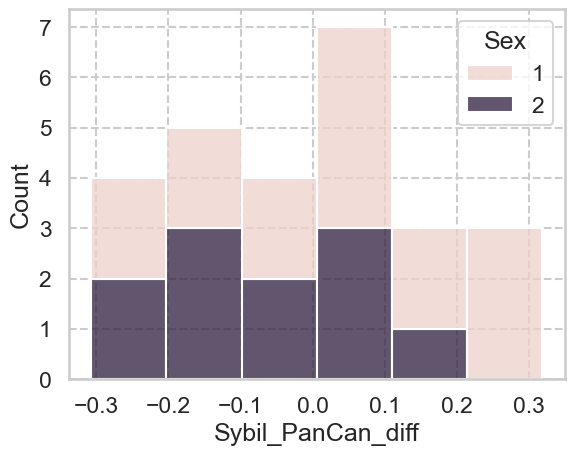

In [54]:
sns.histplot(false_positives, x='Sybil_PanCan_diff', hue='Sex', multiple='stack')

### Gender differences

In [55]:
Sex_fps = {
    "M": false_positives.query("Sex == 1"),
    "F": false_positives.query("Sex == 2"),
}

In [56]:
cat_demo_splits = combine_col_dfs(dlcst_democols['cat'], cat_dist_df, Sex_fps)
display(cat_demo_splits.sort_values(by='diff_norm_M_F', ascending=False))
cat_demo_splits.sort_values(by='diff_norm_M_F', ascending=True)

,category,attribute,value,M_freq,M_norm,F_freq,F_norm,diff_norm_M_F
0,all,Sex,1,15.0,100.0000,0.0,0.0000,100.0000
5,all,Emphysema,1,13.0,86.6667,8.0,72.7273,13.9394
3,all,FamilyHistoryLungCa,1,3.0,20.0000,2.0,18.1818,1.8182
2,all,FamilyHistoryLungCa,0,12.0,80.0000,9.0,81.8182,-1.8182
4,all,Emphysema,0,2.0,13.3333,3.0,27.2727,-13.9394
1,all,Sex,2,0.0,0.0000,11.0,100.0000,-100.0000


,category,attribute,value,M_freq,M_norm,F_freq,F_norm,diff_norm_M_F
1,all,Sex,2,0.0,0.0000,11.0,100.0000,-100.0000
4,all,Emphysema,0,2.0,13.3333,3.0,27.2727,-13.9394
2,all,FamilyHistoryLungCa,0,12.0,80.0000,9.0,81.8182,-1.8182
3,all,FamilyHistoryLungCa,1,3.0,20.0000,2.0,18.1818,1.8182
5,all,Emphysema,1,13.0,86.6667,8.0,72.7273,13.9394
0,all,Sex,1,15.0,100.0000,0.0,0.0000,100.0000


In [57]:
num_demo_splits = combine_col_dfs(dlcst_democols['num'], num_dist_df, Sex_fps)
display(num_demo_splits.sort_values(by='diff_M_F', ascending=False))
num_demo_splits.sort_values(by='diff_M_F', ascending=True)

,category,attribute,value,M,F,diff_M_F
0,all,Age,50%,60.0,58.0000,2.0000
1,all,Age,mean,60.8,59.1818,1.6182
2,all,NoduleCountPerScan,50%,2.0,2.0000,0.0000
3,all,NoduleCountPerScan,mean,1.8,1.9091,-0.1091


,category,attribute,value,M,F,diff_M_F
3,all,NoduleCountPerScan,mean,1.8,1.9091,-0.1091
2,all,NoduleCountPerScan,50%,2.0,2.0000,0.0000
1,all,Age,mean,60.8,59.1818,1.6182
0,all,Age,50%,60.0,58.0000,2.0000


## False Negatives

In [58]:
false_negatives.sort_values(by=['Sybil_PanCan_diff'], ascending=True)[['SeriesInstanceUID', 'label', 'Sybil_pred_label', 'PanCan2b', 'sybil_year1', 'Sybil_PanCan_diff']]

,SeriesInstanceUID,label,Sybil_pred_label,PanCan2b,sybil_year1,Sybil_PanCan_diff
280,1.2.840.113704.1.111.5468.1114095740.10,1,0,0.735168,0.021629,-0.713539
6,1.2.840.113704.1.111.616.1112795278.10,1,0,0.543051,0.001784,-0.541267
180,1.2.840.113704.1.111.4628.1241021790.11,1,0,0.443978,0.010938,-0.433039
456,1.2.840.113704.1.111.208.1128526146.11,1,0,0.282827,0.010938,-0.271888
546,1.2.840.113704.1.111.6216.1133886506.11,1,0,0.262747,0.007145,-0.255602
150,1.2.840.113704.1.111.4760.1105630520.10,1,0,0.223175,0.021629,-0.201546
339,1.2.840.113704.1.111.4452.1190300642.11,1,0,0.167052,0.010938,-0.156113
219,1.2.840.113704.1.111.6252.1187022321.14,1,0,0.147615,0.002824,-0.144790
364,1.2.840.113704.1.111.2776.1158766175.11,1,0,0.129615,0.010938,-0.118677
135,1.2.840.113704.1.111.4540.1105030770.15,1,0,0.130526,0.012097,-0.118429


<Axes: xlabel='Sybil_PanCan_diff', ylabel='Count'>

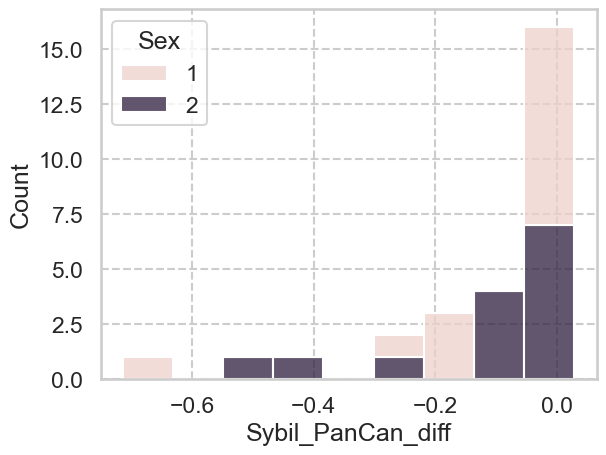

In [59]:
sns.histplot(false_negatives, x='Sybil_PanCan_diff', hue='Sex', multiple='stack')

In [60]:
Sex_fns = {
    "M": false_negatives.query("Sex == 1"),
    "F": false_negatives.query("Sex == 2"),
}

In [61]:
cat_demo_splits = combine_col_dfs(dlcst_democols['cat'], cat_dist_df, Sex_fns)
display(cat_demo_splits.sort_values(by='diff_norm_M_F', ascending=False))
cat_demo_splits.sort_values(by='diff_norm_M_F', ascending=True)

,category,attribute,value,M_freq,M_norm,F_freq,F_norm,diff_norm_M_F
0,all,Sex,1,14.0,100.0000,0.0,0.0000,100.0000
5,all,Emphysema,1,12.0,85.7143,8.0,57.1429,28.5714
2,all,FamilyHistoryLungCa,0,11.0,78.5714,9.0,64.2857,14.2857
3,all,FamilyHistoryLungCa,1,3.0,21.4286,5.0,35.7143,-14.2857
4,all,Emphysema,0,2.0,14.2857,6.0,42.8571,-28.5714
1,all,Sex,2,0.0,0.0000,14.0,100.0000,-100.0000


,category,attribute,value,M_freq,M_norm,F_freq,F_norm,diff_norm_M_F
1,all,Sex,2,0.0,0.0000,14.0,100.0000,-100.0000
4,all,Emphysema,0,2.0,14.2857,6.0,42.8571,-28.5714
3,all,FamilyHistoryLungCa,1,3.0,21.4286,5.0,35.7143,-14.2857
2,all,FamilyHistoryLungCa,0,11.0,78.5714,9.0,64.2857,14.2857
5,all,Emphysema,1,12.0,85.7143,8.0,57.1429,28.5714
0,all,Sex,1,14.0,100.0000,0.0,0.0000,100.0000


In [62]:
num_demo_splits = combine_col_dfs(dlcst_democols['num'], num_dist_df, Sex_fns)
display(num_demo_splits.sort_values(by='diff_M_F', ascending=False))
num_demo_splits.sort_values(by='diff_M_F', ascending=True)

,category,attribute,value,M,F,diff_M_F
1,all,Age,mean,62.2143,58.7857,3.4286
0,all,Age,50%,62.0000,59.0000,3.0000
3,all,NoduleCountPerScan,mean,2.4286,1.7143,0.7143
2,all,NoduleCountPerScan,50%,2.0000,1.5000,0.5000


,category,attribute,value,M,F,diff_M_F
2,all,NoduleCountPerScan,50%,2.0000,1.5000,0.5000
3,all,NoduleCountPerScan,mean,2.4286,1.7143,0.7143
0,all,Age,50%,62.0000,59.0000,3.0000
1,all,Age,mean,62.2143,58.7857,3.4286
